In [60]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime, timedelta
from matplotlib.lines import Line2D
from ipywidgets import interact, widgets
import io

df = pd.read_csv(r"..\Problema2\log_centralizado.log", sep=";")



In [61]:
# Configuración para gráficos más estéticos
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 12

df['t_ini'] = pd.to_datetime(df['t_ini'])
df['t_fin'] = pd.to_datetime(df['t_fin'])

df['duracion_ms'] = (df['t_fin'] - df['t_ini']).dt.total_seconds() * 1000

df['tamano_respuesta_kb'] = df['tamano_respuesta_bytes'].fillna(0) / 1024
#df['tamano_respuesta_mb'] = df['tamano_respuesta_bytes'].fillna(0) / (1024 * 1024)

df['hora'] = df['t_ini'].dt.hour
df['fecha'] = df['t_ini'].dt.date

# rangos etarios grafico1
bins = [0, 18, 25, 35, 50, 100]
labels = ['0-18', '19-25', '26-35', '36-50', '51+']
df['rango_edad'] = pd.cut(df['edad'], bins=bins, labels=labels, right=False)

# 1. Gráfico de torta con porcentaje de consulta por rango etario

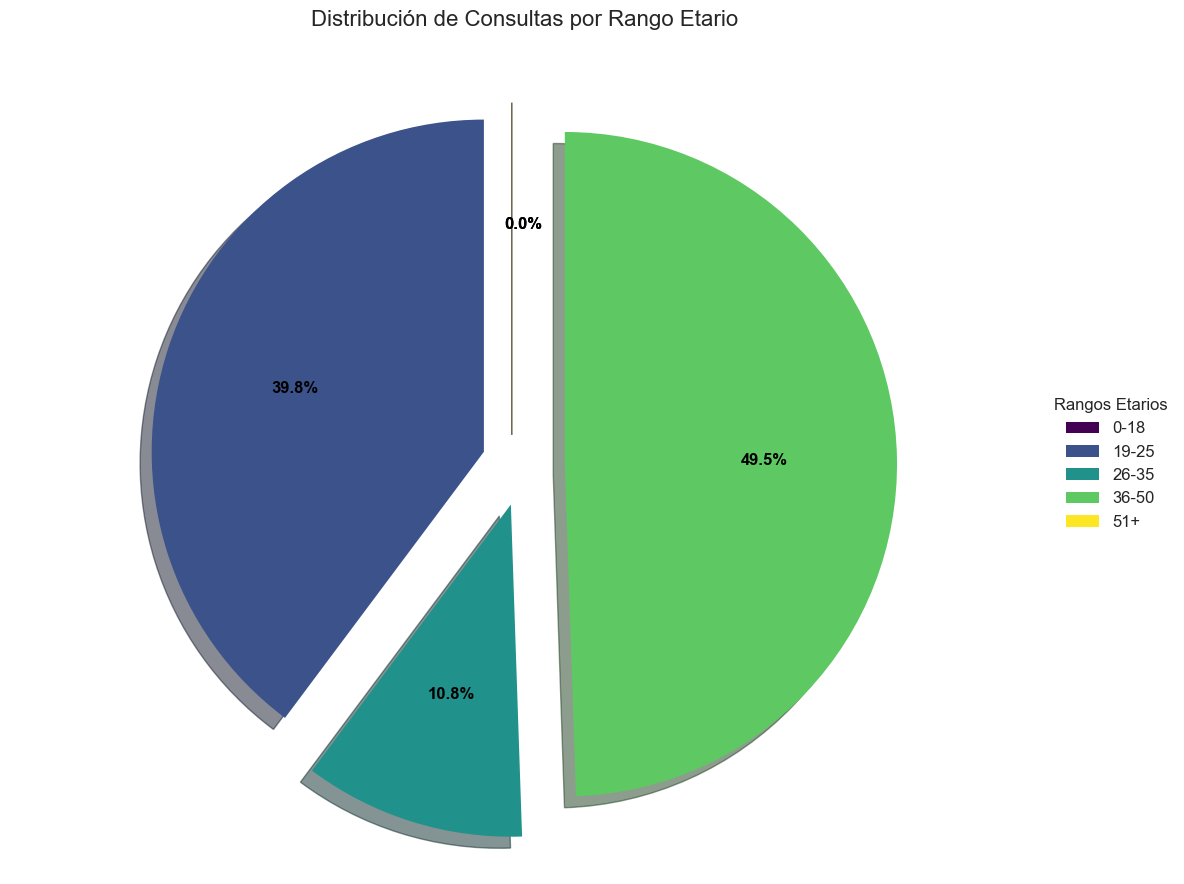

In [62]:
df_busquedas = df[df['operacion'] == 'busqueda en db']

plt.figure(figsize=(12, 9))

conteo_por_rango = df_busquedas['rango_edad'].value_counts().sort_index()
porcentajes = conteo_por_rango / conteo_por_rango.sum() * 100
    
colors = plt.cm.viridis(np.linspace(0, 1, len(porcentajes)))
explode = [0.1] * len(porcentajes)  
    

wedges, texts, autotexts = plt.pie(
    porcentajes, 
    labels=None,  
    autopct='%1.1f%%',
    startangle=90,
    explode=explode,
    colors=colors,
    shadow=True,
    radius=0.8 
)
    

for autotext in autotexts:
    autotext.set_fontsize(12)
    autotext.set_color('black')  
    autotext.set_fontweight('bold')  
    
    
plt.legend(
    wedges, 
    porcentajes.index,
    title="Rangos Etarios",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)
plt.title('Distribución de Consultas por Rango Etario', fontsize=16, pad=20)
plt.axis('equal')  # Para que el gráfico sea circular
plt.tight_layout()
plt.show()  

# 2. Curvas de promedios de score a través del tiempo con ventanas variables

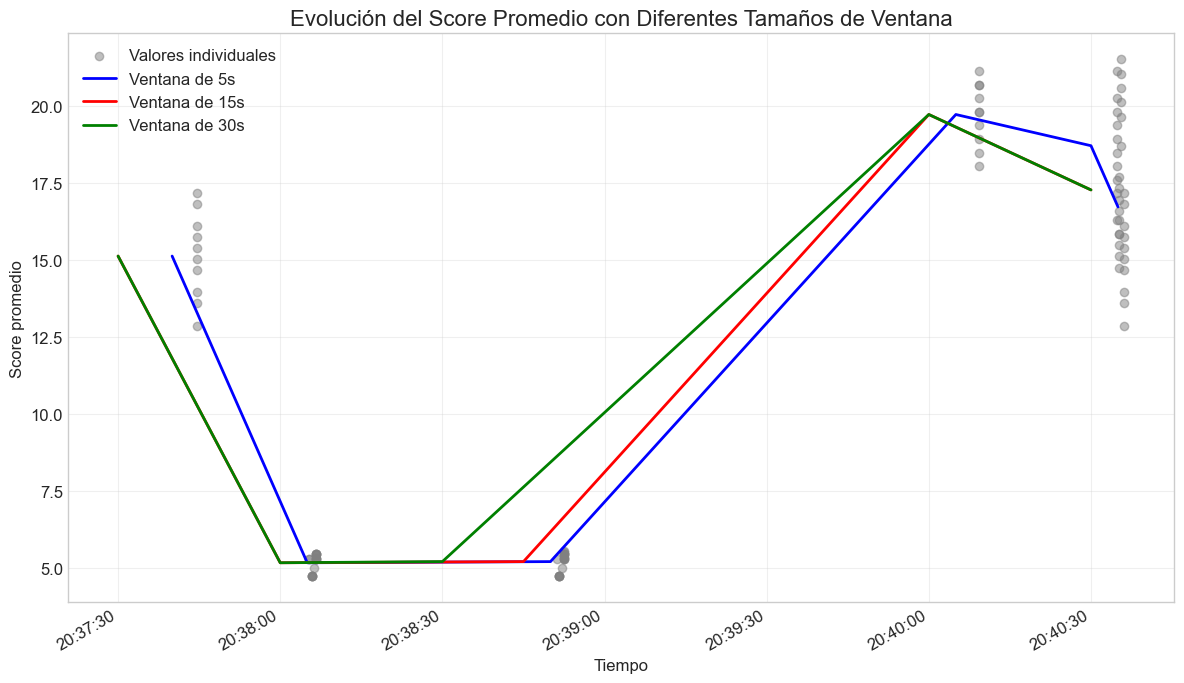

In [63]:
df['t_ini'] = pd.to_datetime(df['t_ini'])
df['t_fin'] = pd.to_datetime(df['t_fin'])

# Filtrar solo registros de búsqueda en db con ranking válido
df_ranking = df[(df['operacion'] == 'busqueda en db') & (~df['ranking'].isna())].copy()

df_ranking = df_ranking.sort_values('t_ini')

plt.figure(figsize=(12, 7))

if len(df_ranking) < 2:
    plt.text(0.5, 0.5, 'No hay suficientes datos de ranking para analizar', 
             ha='center', va='center', fontsize=14)
    plt.axis('off')
else:
    plt.scatter(df_ranking['t_ini'], df_ranking['ranking'], alpha=0.5, 
             color='gray', label='Valores individuales')
    ventanas = ['5s', '15s', '30s']
    colores = ['blue', 'red', 'green']
    
    for i, ventana in enumerate(ventanas):
        df_temp = df_ranking.set_index('t_ini')
        promedio_tiempo = df_temp['ranking'].resample(ventana).mean()
        promedio_tiempo = promedio_tiempo.dropna()
        if not promedio_tiempo.empty:
            plt.plot(promedio_tiempo.index, promedio_tiempo.values, 
                     linewidth=2, color=colores[i], label=f'Ventana de {ventana}')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    plt.gcf().autofmt_xdate() 
    
    plt.xlabel('Tiempo', fontsize=12)
    plt.ylabel('Score promedio', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.title('Evolución del Score Promedio con Diferentes Tamaños de Ventana', fontsize=16)
plt.tight_layout()
plt.show()

# 3. Gráfico de cajas para tiempos promedio, min, max por esclavo (puerto)

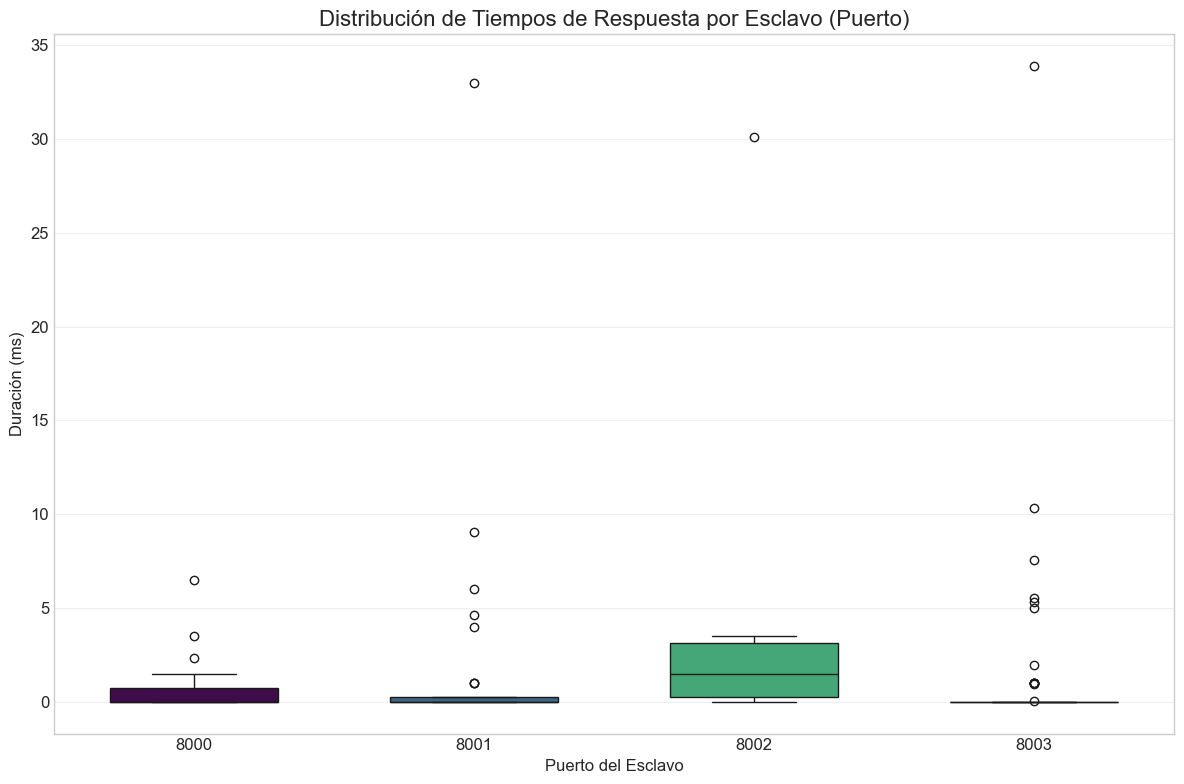

In [64]:
df_tiempos = df[df['operacion'].isin(['busqueda en db', 'mandar_resultados_a_master'])].copy()

plt.figure(figsize=(12, 8))

if len(df_tiempos) < 5:  
    plt.text(0.5, 0.5, 'No hay suficientes datos de tiempos para analizar', 
             ha='center', va='center', fontsize=14)
    plt.axis('off')
else:
    sns.boxplot(x='puerto_maquina', y='duracion_ms', hue='puerto_maquina', 
                data=df_tiempos, palette='viridis', width=0.6, legend=False)
    
    plt.xlabel('Puerto del Esclavo', fontsize=12)
    plt.ylabel('Duración (ms)', fontsize=12)
    plt.grid(True, axis='y', alpha=0.3)
    
    for puerto in df_tiempos['puerto_maquina'].unique():
        tiempos = df_tiempos[df_tiempos['puerto_maquina'] == puerto]['duracion_ms']
        if not tiempos.empty:
            y_pos = tiempos.max() + (tiempos.max() * 0.05)
            plt.annotate(f'Min: {tiempos.min():.2f}\nMax: {tiempos.max():.2f}\nPromedio: {tiempos.mean():.2f}', 
                         xy=(puerto, y_pos),
                         ha='center', va='bottom',
                         bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.3))

plt.title('Distribución de Tiempos de Respuesta por Esclavo (Puerto)', fontsize=16)
plt.tight_layout()
plt.show()

# 4. Latencia de red entre maestro y esclavos

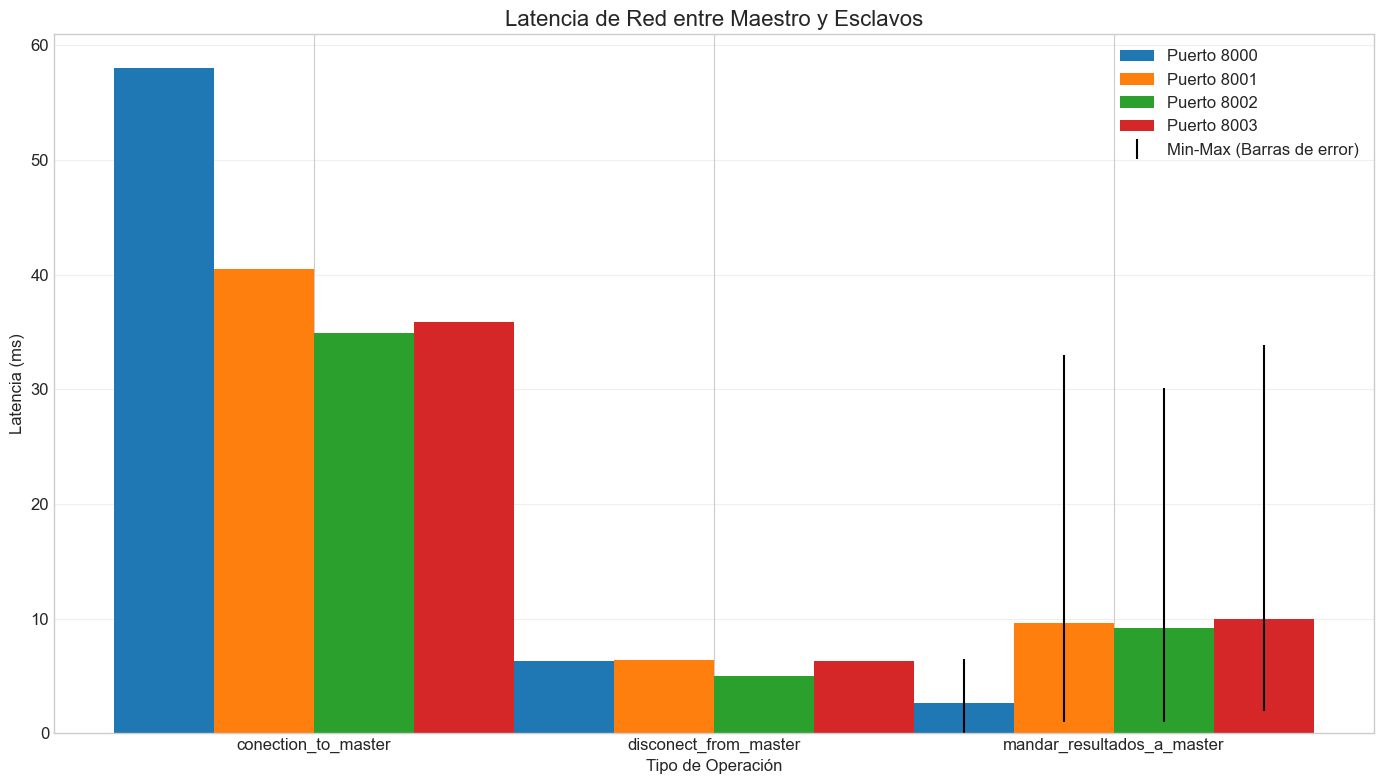

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Asumimos que ya tenemos el dataframe df con los datos procesados
df_red = df[df['operacion'].isin(['conection_to_master', 
                                 'mandar_resultados_a_master', 
                                 'disconect_from_master'])].copy()

plt.figure(figsize=(14, 8))

if len(df_red) < 3:  
    plt.text(0.5, 0.5, 'No hay suficientes datos de latencia para analizar', 
             ha='center', va='center', fontsize=14)
    plt.axis('off')
else:
    # Agrupar por tipo de operación y puerto
    df_latencia = df_red.groupby(['operacion', 'puerto_maquina'])['duracion_ms'].agg(['mean', 'min', 'max']).reset_index()
    
    # Obtener las operaciones únicas
    operaciones = df_latencia['operacion'].unique()
    n_operaciones = len(operaciones)
    
    # Crear barras agrupadas por tipo de operación
    bar_width = 0.25
    r = np.arange(n_operaciones)
    
    # Graficar barras para cada puerto
    puertos = df_latencia['puerto_maquina'].unique()
    bar_containers = []  # Almacenar los contenedores de barras para la leyenda
    
    for i, puerto in enumerate(puertos):
        # Filtrar solo las filas de este puerto
        df_puerto = df_latencia[df_latencia['puerto_maquina'] == puerto]
        
        # Crear un arreglo de posiciones para este puerto
        bar_positions = []
        bar_heights = []
        yerr_data = []
        
        # Para cada operación, buscar si existe un dato para este puerto
        for op_idx, op in enumerate(operaciones):
            op_data = df_puerto[df_puerto['operacion'] == op]
            if not op_data.empty:
                bar_positions.append(r[op_idx] + i*bar_width)
                bar_heights.append(op_data['mean'].values[0])
                
                # Calcular error superior e inferior para esta barra
                lower_err = op_data['mean'].values[0] - op_data['min'].values[0]
                upper_err = op_data['max'].values[0] - op_data['mean'].values[0]
                yerr_data.append([lower_err, upper_err])
        
        # Convertir a arrays numpy
        bar_positions = np.array(bar_positions)
        bar_heights = np.array(bar_heights)
        yerr_data = np.array(yerr_data).T  # Transponer para tener forma (2, n)
        
        # Dibujar las barras solo si hay datos
        if len(bar_positions) > 0:
            # Almacenar el contenedor de barras para la leyenda
            container = plt.bar(bar_positions, bar_heights, 
                    width=bar_width, label=f'Puerto {puerto}',
                    yerr=yerr_data)
            bar_containers.append(container)
    
    plt.xlabel('Tipo de Operación', fontsize=12)
    plt.ylabel('Latencia (ms)', fontsize=12)
    plt.xticks(r + bar_width*(len(puertos)-1)/2, operaciones)
    
    # Crear una leyenda personalizada que incluya las barras de error
    handles, labels = plt.gca().get_legend_handles_labels()
    
    # Añadir un elemento de leyenda para las barras de error
    error_bar = Line2D([0], [0], color='black', linewidth=2, linestyle='none', 
                        marker='|', markersize=15, markeredgewidth=1.5, label='Min-Max (Barras de error)')
    
    # Añadir el elemento de barras de error a los handles
    handles.append(error_bar)
    
    # Crear la leyenda con todos los elementos
    plt.legend(handles=handles)
    
    plt.grid(True, axis='y', alpha=0.3)

plt.title('Latencia de Red entre Maestro y Esclavos', fontsize=16)
plt.tight_layout()
plt.show()

# 5. Tamaño en MB de las respuestas por hora a través del día

In [66]:
# Filtrar solo los registros de envío de resultados
df_respuestas = df[df['operacion'] == 'mandar_resultados_a_master'].copy()

# Función para graficar por fecha seleccionada
def graficar_por_fecha(fecha_sel):
    plt.figure(figsize=(14, 8))

    df_fecha = df_respuestas[df_respuestas['fecha'] == fecha_sel]
    if df_fecha.empty:
        plt.text(0.5, 0.5, 'No hay datos para esta fecha seleccionada', 
                 ha='center', va='center', fontsize=14)
        plt.axis('off')
        plt.show()
        return

    df_por_hora = df_fecha.groupby('hora')['tamano_respuesta_kb'].agg(['sum', 'count']).reset_index()
    df_por_hora = df_por_hora.sort_values('hora')

    plt.plot(df_por_hora['hora'], df_por_hora['sum'], 'o-', linewidth=2, markersize=8, label=f'Fecha: {fecha_sel}')

    plt.xlabel('Hora del día', fontsize=12)
    plt.ylabel('Tamaño total de respuestas (KB)', fontsize=12)
    plt.xticks(range(0, 24))
    plt.grid(True, alpha=0.3)

    for _, row in df_por_hora.iterrows():
        plt.annotate(f"{int(row['count'])} resp.", 
                     (row['hora'], row['sum']),
                     textcoords="offset points", 
                     xytext=(0,10), 
                     ha='center',
                     fontsize=9)

    plt.legend()

    # Segundo eje Y en bytes
    ax2 = plt.gca().twinx()
    ax2.set_ylabel('Tamaño en bytes', fontsize=12)
    y1, y2 = plt.gca().get_ylim()
    ax2.set_ylim([y1 * 1024, y2 * 1024])

    plt.title('Tamaño de Respuestas por Hora', fontsize=16)
    plt.tight_layout()
    plt.show()

# Crear el selector interactivo de fechas disponibles
fechas_disponibles = sorted(df_respuestas['fecha'].unique())
interact(graficar_por_fecha, fecha_sel=widgets.Dropdown(options=fechas_disponibles, description='Fecha:'))


interactive(children=(Dropdown(description='Fecha:', options=(datetime.date(2025, 5, 10),), value=datetime.dat…

<function __main__.graficar_por_fecha(fecha_sel)>